# NIR Notebook Test
20 Dec 2013 v6

### Big steps

1. Check NIR Arduino may need to reinstall software - see Arduino file for that (insert)
   - current arduino file - `button_nir_v_04.ino`

2. Set up a virtual Python environment for Visual Studio Code

   ```shell
   cd path/to/your/project
   
   python3 -m venv nir
   
   source nir/bin/activate
   ```

3.  Install the files below

### Packages

Built-in packages are: time, os, csv

1. pyserial
2. schedule
3. matplotlib

### Run the Notebook

1. If the first time, then you can run all
2. If you want to collect different samples you can start with 2. Serial communication with Arduino
3. Proceed cell by cell to collect data

## 1. Serial Communications
This code block below reads what your serial port the Arduino is at and prints that out. You may need to update the cell below with that information. Since on windows serial ports change frequently.

In [ ]:
import serial
import serial.tools.list_ports
def list_serial_ports():
    ports = serial.tools.list_ports.comports()
    for port in ports:
        print(port)
if __name__ == '__main__':
    list_serial_ports()

## 2. Serial communication with Arduino
1. Check the above print out
2. Find the Arduino board "SparkFun SAMD51 MicroMod" serial port "COM8" or "/dev/cu.usbmodem12301" something like these and put into the code.

In [ ]:
import time
import schedule
carry_values = []
def main_func():
    global carry_values
    try:
        # change your serial port
        #arduino = serial.Serial('COM8', 115200, timeout=1)#windows flavor
        arduino = serial.Serial('/dev/cu.usbmodem12401', 115200, timeout=1)#linux and MacOS flavor
        print('Established serial connection to Arduino')
    except Exception as e:
        print(f'Failed to connect: {e}')
        return
    arduino_data = arduino.readline()
    if not arduino_data:
        print('No data received from Arduino. Exiting...')
        arduino.close()
        return 'exit'
    decoded_values = str(arduino_data[0:len(arduino_data)].decode("utf-8"))
    list_values = decoded_values.split(',')
    list_values= list_values[:-1]
    carry_values = []
    for item in list_values:
        carry_values.append(float(item))
    print(f'Collected readings from Arduino: {carry_values}')
    arduino_data = 0
    arduino.close()
    print('Connection closed')
    print('<----------------------------->')
print('Program started')
schedule.every(5).seconds.do(main_func)
start_time = time.time()
while True:
    result = schedule.run_pending()
    if result == 'exit':
        break
    time.sleep(1)
    elapsed_time = time.time() - start_time
    if elapsed_time > 15:
        print('graph')
        print(f'Graph: {carry_values}')
        break

## 3. Initial Plot
Plots the current reading

In [ ]:
import matplotlib.pyplot as plt
#carry_values = [1021.96, 485.59, 1090.37, 413.11, 787.75, 1186.35, 437.41, 560.83, 2201.98, 416.03, 671.91, 134.69, 202.98, 146.25, 479.8, 950.51, 335.93]
x_values = [410, 435, 460, 485, 510, 535, 560, 585, 610, 645, 680, 705, 730, 760, 810, 860, 900]
plt.figure(figsize=(10,5))
plt.plot(x_values, carry_values, marker='o')
plt.title('Response over Wavelength')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Response')
plt.grid(True)
plt.show()

## 4. Saves out data to CVS text file
1. The file is named "samples_01.csv" you can change it if you want
2. You will be asked to enter the name of the material in pop-up window on the top of the notebook, enter the name make sure it is one word e.g. "yellow_cloth"
3. The info will be saved into the text file.

In [ ]:
import csv
import os
filename = 'samples_13_close.csv'
item = input('Please add a new item at the end of the list (a text string): ')
carry_values.append(item)
file_exists = os.path.isfile(filename)
with open(filename, mode='a', newline='') as file:
    writer = csv.writer(file)
    if not file_exists:
        writer.writerow(['410', '435', '460', '485', '510', '535', '560', '585', '610', '645', '680', '705', '730', '760', '810', '860', '900', 'Material', 'Additional Item'])
    writer.writerow(carry_values + [item])
print(f'Data has been saved to {filename}')

## 5. Plot of all your saved samples

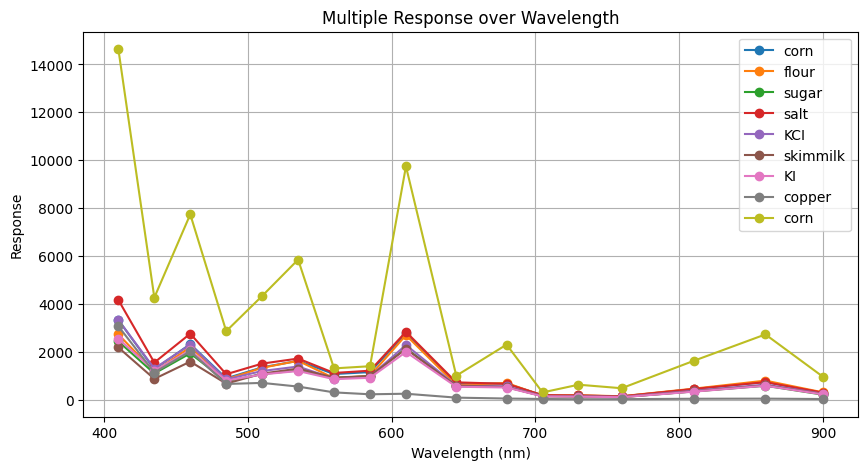

In [1]:
import csv
import matplotlib.pyplot as plt

# File path
filename = 'samples_13.csv'

# Initialize the plot
plt.figure(figsize=(10, 5))

with open(filename, mode='r') as file:
    reader = csv.reader(file)
    x_values = next(reader)[:-2]  # Read the first row and exclude the last two items
    x_values = [float(x) for x in x_values]  # Convert x-axis values to float

    for row in reader:
        try:
            carry_values = [float(value) for value in row[:-2]]  # Exclude the last two items
        except ValueError as e:
            print(f'Error converting value to float: {e}')
            continue  # Skip to the next row if there is an error converting value

        if len(x_values) != len(carry_values):
            print(f'Skipping row due to length mismatch: x_values length: {len(x_values)}, carry_values length: {len(carry_values)}')
            continue  # Skip to the next row if there is a length mismatch

        legend_item = row[-2]  # Use the second last item as legend
        plt.plot(x_values, carry_values, marker='o', label=legend_item)

# Set the plot title and labels
plt.title('Multiple Response over Wavelength')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Response')
plt.legend(loc='upper right')
plt.grid(True)

# Display the plot
plt.show()


## Salt Baseline

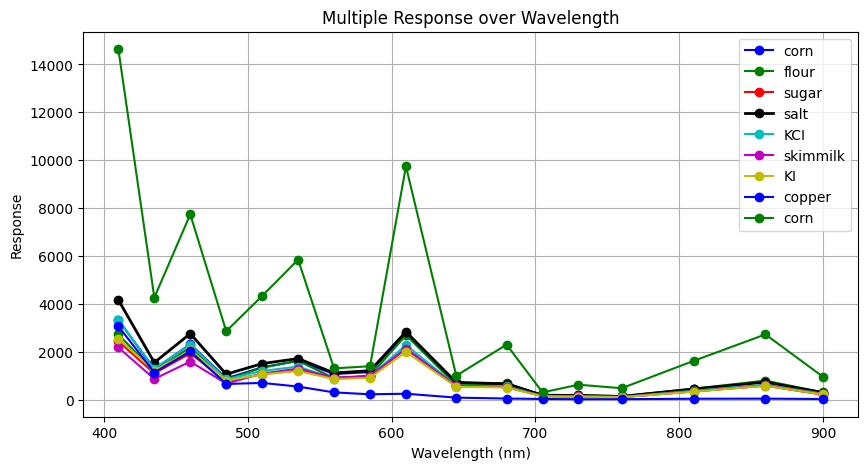

In [5]:
import csv
import itertools
import matplotlib.pyplot as plt

# File path

# Corrected code with the color iterator outside the loop

# Define a color palette (excluding black for 'salt')
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y'])

# Re-plotting with the corrected code
plt.figure(figsize=(10, 5))

file_path = 'samples_13.csv'  # Replace with the actual file path
with open(file_path, mode='r') as file:  # Using the absolute path
    reader = csv.reader(file)
    x_values = next(reader)[:-2]  # Read the first row and exclude the last two items
    x_values = [float(x) for x in x_values]  # Convert x-axis values to float

    for row in reader:
        try:
            carry_values = [float(value) for value in row[:-2]]  # Exclude the last two items
        except ValueError as e:
            print(f'Error converting value to float: {e}')
            continue

        if len(x_values) != len(carry_values):
            print(f'Skipping row due to length mismatch: x_values length: {len(x_values)}, carry_values length: {len(carry_values)}')
            continue

        legend_item = row[-2]  # Use the second last item as legend
        if legend_item.lower() == 'salt':
            # Plot 'salt' with black color and thicker line
            plt.plot(x_values, carry_values, marker='o', label=legend_item, color='k', linewidth=2)
        else:
            color = next(colors)  # Get the next color from the palette for other lines
            plt.plot(x_values, carry_values, marker='o', label=legend_item, color=color)

# Set the plot title and labels
plt.title('Multiple Response over Wavelength')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Response')
plt.legend(loc='upper right')
plt.grid(True)

# Display the plot
plt.show()


## Differnces

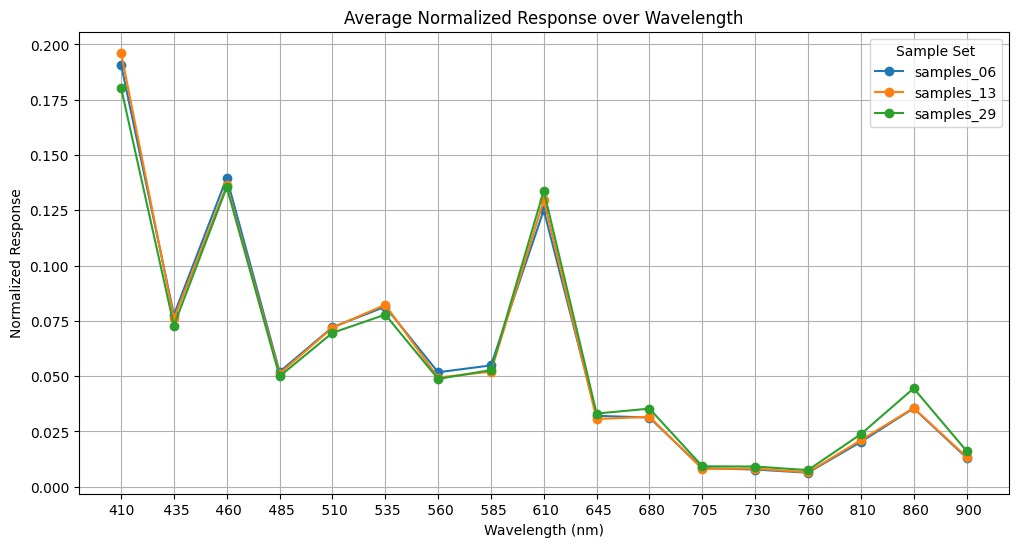

Table of Average Normalized Responses:
      samples_06  samples_13  samples_29
410     0.190916    0.196245    0.180455
 435    0.077701    0.076105    0.072872
 460    0.139640    0.136260    0.135413
 485    0.051981    0.051126    0.049913
 510    0.072100    0.071907    0.069576
 535    0.081391    0.082258    0.077810
 560    0.051750    0.049327    0.048745
 585    0.054854    0.052067    0.052728
 610    0.125075    0.129621    0.133814
 645    0.032053    0.030603    0.033081
 680    0.031267    0.031607    0.035304
 705    0.008377    0.008092    0.009233
 730    0.007763    0.008155    0.009119
 760    0.006321    0.006480    0.007502
 810    0.020261    0.021054    0.023753
 860    0.035457    0.035592    0.044486
 900    0.013091    0.013500    0.016197


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# Function to read and normalize data
def read_and_normalize(file_path):
    df = pd.read_csv(file_path)
    # Assuming the last two columns are non-numeric (labels, etc.), and the rest are the data to be normalized
    data_columns = df.columns[:-2]
    # Normalize such that each row sums to 1
    df_normalized = df[data_columns].div(df[data_columns].sum(axis=1), axis=0)
    return df_normalized

# File paths
file_paths = ['samples_06.csv', 'samples_13.csv', 'samples_29.csv']

# Read and normalize data from each file
normalized_data = [read_and_normalize(file) for file in file_paths]

# Calculate average normalized response at each wavelength for each file
average_responses = [df.mean() for df in normalized_data]

# Extracting wavelength values from the columns (assuming all files have the same wavelengths)
wavelengths = normalized_data[0].columns

# Creating a DataFrame for easier plotting
average_responses_df = pd.DataFrame(average_responses, index=['samples_06', 'samples_13', 'samples_29'])
average_responses_df = average_responses_df.T  # Transpose for easier plotting

# Plotting the average responses
plt.figure(figsize=(12, 6))

for sample_id in average_responses_df.columns:
    plt.plot(wavelengths, average_responses_df[sample_id], marker='o', label=sample_id)

plt.title('Average Normalized Response over Wavelength')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Response')
plt.legend(title='Sample Set')
plt.grid(True)

# Display the plot
plt.show()

# Printing the table of average responses
print("Table of Average Normalized Responses:")
print(average_responses_df)

## Sensor distancce
- 3.5 CM away the tube
- 1.3 CM away 

Paint it black